In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 20% for validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    r"C:\Users\sukis\Downloads\AugmentedAlzheimerDataset",
    
    target_size=IMAGE_SIZE,
    color_mode='grayscale',  # Assuming grayscale MRI images
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    r"C:\Users\sukis\Downloads\AugmentedAlzheimerDataset",
    
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
train_dir = r"C:\mini project\train1"
validation_dir = r"C:\mini project\navigate2"

# ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Rescale pixel values to [0, 1]
    rotation_range=20,     # Randomly rotate images
    width_shift_range=0.2, # Randomly shift images horizontally
    height_shift_range=0.2,# Randomly shift images vertically
    shear_range=0.2,       # Randomly shear images
    zoom_range=0.2,        # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'    # Fill pixels after transformations
)

# ImageDataGenerator for validation (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load and prepare the training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # Resize images to 224x224
    batch_size=32,          # Number of images to yield per batch
    class_mode='binary'     # Binary classification
)

# Load and prepare the validation dataset
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224), # Resize images to 224x224
    batch_size=32,          # Number of images to yield per batch
    class_mode='binary'     # Binary classification
)


Found 33984 images belonging to 4 classes.
Found 33984 images belonging to 4 classes.


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    
    # Add custom layers on top of ResNet50 base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model():
    # Load the ResNet50 model with pre-trained weights, without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Create a new input layer for grayscale images (single channel)
    input_layer = Input(shape=(224, 224, 1))
    
    # Convert grayscale input to 3 channels by duplicating the single channel
    x = tf.keras.layers.Concatenate()([input_layer, input_layer, input_layer])
    
    # Apply the modified input through the ResNet50 base model
    x = base_model(x, training=False)  # Ensure the base model is not trainable during this step
    
    # Add custom layers on top of the base model
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Create the final model
    model = Model(inputs=input_layer, outputs=predictions)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ concatenate[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 12,845,184 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,433,025 (138.98 MB)

 Trainable params: 12,845,313 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model():
    # Load the ResNet50 model with pre-trained weights, without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Create a new input layer for grayscale images (single channel)
    input_layer = Input(shape=(224, 224, 1))
    
    # Convert grayscale input to 3 channels by duplicating the single channel
    x = tf.keras.layers.Concatenate()([input_layer, input_layer, input_layer])
    
    # Apply the modified input through the ResNet50 base model
    x = base_model(x, training=False)  # Ensure the base model is not trainable during this step
    
    # Add custom layers on top of the base model
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Create the final model
    model = Model(inputs=input_layer, outputs=predictions)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the model
model = create_model()

# Example data
import numpy as np
x_train = np.random.random((10, 224, 224, 1))  # Dummy grayscale images
y_train = np.random.randint(2, size=(10, 1))  # Dummy binary labels

# Fit the model
history = model.fit(x_train, y_train, epochs=5, batch_size=2)


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.2611 - loss: 1.8555
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.3264 - loss: 1.0418
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.3222 - loss: 1.6741
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.4458 - loss: 0.9745
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.5014 - loss: 1.4154


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define parameters
image_directory = (r"C:\Users\sukis\Downloads\AugmentedAlzheimerDataset")  # Replace with your dataset directory
batch_size = 32
img_height = 224
img_width = 224

# Load images from the directory
dataset = image_dataset_from_directory(
    image_directory,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',  # Assuming images are grayscale
    label_mode=None  # Set to None to only load images for prediction
)

# Define the model
def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    input_layer = Input(shape=(224, 224, 1))
    x = tf.keras.layers.Concatenate()([input_layer, input_layer, input_layer])
    x = base_model(x, training=False)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the model
model = create_model()

# Make predictions on the dataset
predictions = model.predict(dataset)

# Print predictions
for i, prediction in enumerate(predictions):
    print(f'Image {i+1} prediction: {prediction}')


Found 33984 files.
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1396s 1s/step
Image 1 prediction: [0.34272924]
Image 2 prediction: [0.70253813]
Image 3 prediction: [0.8788559]
Image 4 prediction: [0.62861973]
Image 5 prediction: [0.91945815]
Image 6 prediction: [0.71997845]
Image 7 prediction: [0.9832827]
Image 8 prediction: [0.5051936]
Image 9 prediction: [0.63585734]
Image 10 prediction: [0.7994658]
Image 11 prediction: [0.8256567]
Image 12 prediction: [0.9687768]
Image 13 prediction: [0.72546697]
Image 14 prediction: [0.67037535]
Image 15 prediction: [0.83477366]
Image 16 prediction: [0.6433604]
Image 17 prediction: [0.89477134]
Image 18 prediction: [0.8324263]
Image 19 prediction: [0.9638255]
Image 20 prediction: [0.78442067]
Image 21 prediction: [0.6384063]
Image 22 prediction: [0.47100055]
Image 23 prediction: [0.17246509]
Image 24 prediction: [0.9145021]
Image 25 prediction: [0.7670494]
Image 26 prediction: [0.35718647]
Image 27 prediction: [0.9399557]
Image 28 prediction: [0.9107524]
Image 2

In [11]:
model.save('alzheimers_detection_model.h5')
print("Model saved as 'alzheimers_detection_model.h5'")

Model saved as 'alzheimers_detection_model.h5'


In [12]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load the saved model
model = load_model('alzheimers_detection_model.h5')

# Function to preprocess a new MRI image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224, 224))
    img_normalized = img_resized / 255.0
    img_reshaped = np.expand_dims(img_normalized, axis=[0, -1])
    return img_reshaped

# Test the model with a new image
image_path = (r"C:\Users\sukis\Downloads\fed8fc3d-3ded-42bb-8f50-82679adbab42.jpg")
preprocessed_image = preprocess_image(image_path)
prediction = model.predict(preprocessed_image)
result = "Alzheimer's Detected" if prediction > 0.5 else "No Alzheimer's Detected"
print(f"Prediction: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Alzheimer's Detected


In [13]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to perform region growing
def region_growing(img, seed, threshold):
    mask = np.zeros_like(img)
    height, width = img.shape
    region_points = [seed]
    mask[seed] = 255
    seed_value = img[seed]

    while region_points:
        current_point = region_points.pop(0)
        current_x, current_y = current_point

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                neighbor_x = current_x + dx
                neighbor_y = current_y + dy
                if (0 <= neighbor_x < width) and (0 <= neighbor_y < height):
                    if mask[neighbor_y, neighbor_x] == 0:
                        if abs(int(img[neighbor_y, neighbor_x]) - int(seed_value)) <= threshold:
                            mask[neighbor_y, neighbor_x] = 255
                            region_points.append((neighbor_x, neighbor_y))

    return mask

# Define the seed point and threshold
seed_point = (150, 100)  # Adjust this according to your dataset
threshold_value = 10  # Adjust this according to your dataset

# Directories
input_dir = (r"C:\mini project\train1") # Directory containing the MRI images
output_dir = (r"C:\mini project\outout")  # Directory to save the segmented images

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each image in the dataset
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        # Load the MRI image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Display the seed point on the original image for verification
        image_with_seed = image.copy()
        cv2.circle(image_with_seed, seed_point, 5, (255, 0, 0), -1)  # Red dot at the seed point

        # Perform region growing segmentation
        segmented_region = region_growing(image, seed_point, threshold_value)

        # Save the segmented image
        output_path = os.path.join(output_dir, f'segmented_{filename}')
        cv2.imwrite(output_path, segmented_region)

        # Display the seed point and segmentation result
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Original MRI Image')
        plt.imshow(image, cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title('Seed Point')
        plt.imshow(image_with_seed, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title('Segmented Region')
        plt.imshow(segmented_region, cmap='gray')
        plt.show()

print("Segmentation complete for all images in the dataset.")

  


Segmentation complete for all images in the dataset.


In [14]:
!pip install matplotlib





[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\sukis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


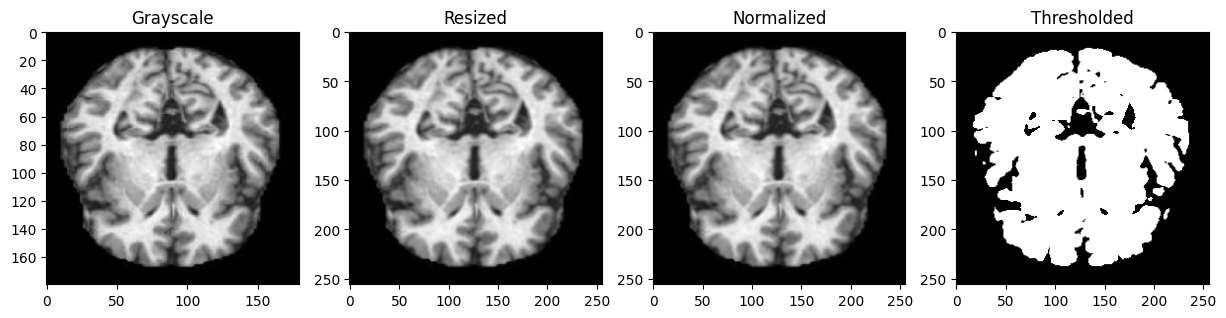

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, filters, transform

# Function to apply preprocessing steps: grayscale, resizing, normalization, thresholding
def preprocess_mri(image):
    # Convert to grayscale
    gray_img = color.rgb2gray(image)
    
    # Resize to standard dimensions
    resized_img = transform.resize(gray_img, (256, 256))
    
    # Normalize the image
    norm_img = (resized_img - np.mean(resized_img)) / np.std(resized_img)
    
    # Apply thresholding
    thresh = filters.threshold_otsu(norm_img)
    binary_img = norm_img > thresh
    
    return gray_img, resized_img, norm_img, binary_img

# Load a sample MRI image (replace with your dataset loading)
sample_image = plt.imread(r"C:\Users\sukis\Downloads\fed8fc3d-3ded-42bb-8f50-82679adbab42.jpg")  # Replace with actual path to an MRI image

# Preprocess image
gray_img, resized_img, norm_img, binary_img = preprocess_mri(sample_image)

# Visualize the preprocessing steps similar to the uploaded example
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(gray_img, cmap='gray')
axes[0].set_title('Grayscale')
axes[1].imshow(resized_img, cmap='gray')
axes[1].set_title('Resized')
axes[2].imshow(norm_img, cmap='gray')
axes[2].set_title('Normalized')
axes[3].imshow(binary_img, cmap='gray')
axes[3].set_title('Thresholded')

plt.show()

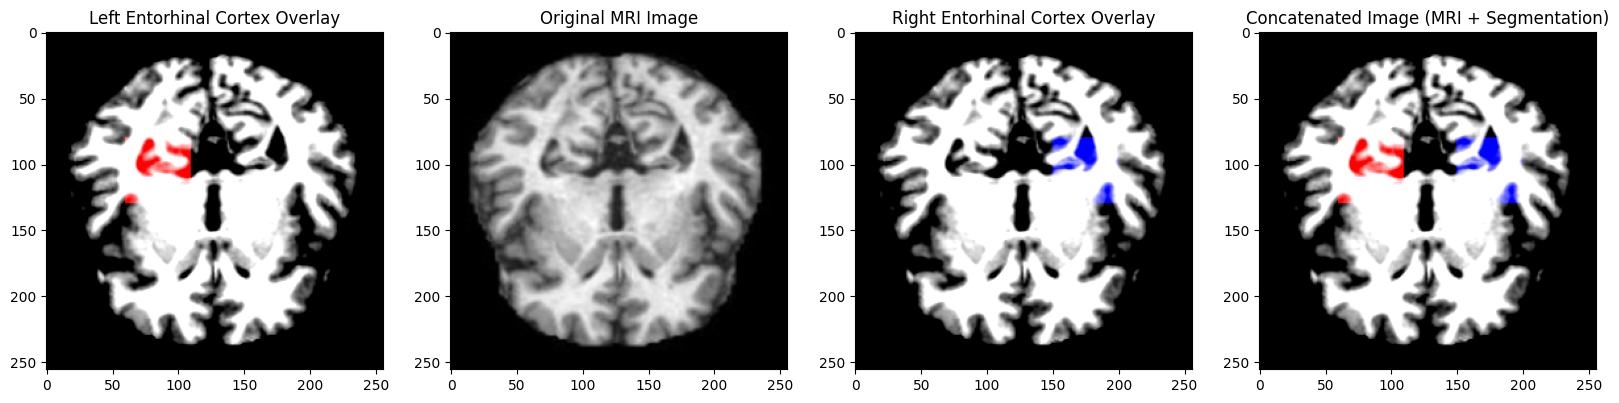

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# U-Net segmentation function
def unet_segmentation(preprocessed_image):
    # Dummy masks for the left and right entorhinal cortex (simulated for this example)
    # These will have values of 0 (background) or 1 (foreground)
    segmented_left = np.zeros(preprocessed_image.shape[:2], dtype=np.uint8)
    segmented_right = np.zeros(preprocessed_image.shape[:2], dtype=np.uint8)
    
    # Simulate segmentation with small regions as 1 (foreground)
    # Replace this with your actual U-Net prediction logic.
    segmented_left[80:130, 60:110] = 1  # Left mask
    segmented_right[80:130, 150:200] = 1  # Right mask
    
    return segmented_left, segmented_right

# Function to overlay segmentation masks on the original image with transparency
def overlay_segmentation_on_image(image, left_seg, right_seg):
    # Convert grayscale image to 3-channel (RGB) for visualization
    overlay_img = np.stack([image, image, image], axis=-1)  # Grayscale to RGB
    
    # Define color intensities for the left (red) and right (blue) masks
    red_intensity = 0.7  # Red for left segmentation
    blue_intensity = 0.7  # Blue for right segmentation
    
    # Apply left segmentation mask in the red channel
    overlay_img[:, :, 0] = np.where(left_seg == 1, red_intensity * 255 + (1 - red_intensity) * overlay_img[:, :, 0], overlay_img[:, :, 0])
    
    # Apply right segmentation mask in the blue channel
    overlay_img[:, :, 2] = np.where(right_seg == 1, blue_intensity * 255 + (1 - blue_intensity) * overlay_img[:, :, 2], overlay_img[:, :, 2])
    
    return overlay_img

# Perform segmentation on the normalized MRI image
segmented_left, segmented_right = unet_segmentation(norm_img)

# Concatenate the image and segmentation results
overlay_img = overlay_segmentation_on_image(norm_img, segmented_left, segmented_right)

# Visualize the segmentation results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Display left segmentation overlaid on the MRI
axes[0].imshow(overlay_segmentation_on_image(norm_img, segmented_left, np.zeros_like(segmented_left)))
axes[0].set_title('Left Entorhinal Cortex Overlay')

# Display original MRI image
axes[1].imshow(norm_img, cmap='gray')
axes[1].set_title('Original MRI Image')

# Display right segmentation overlaid on the MRI
axes[2].imshow(overlay_segmentation_on_image(norm_img, np.zeros_like(segmented_right), segmented_right))
axes[2].set_title('Right Entorhinal Cortex Overlay')

# Display both left and right segmentations overlaid on the MRI
axes[3].imshow(overlay_img)
axes[3].set_title('Concatenated Image (MRI + Segmentation)')

plt.show()

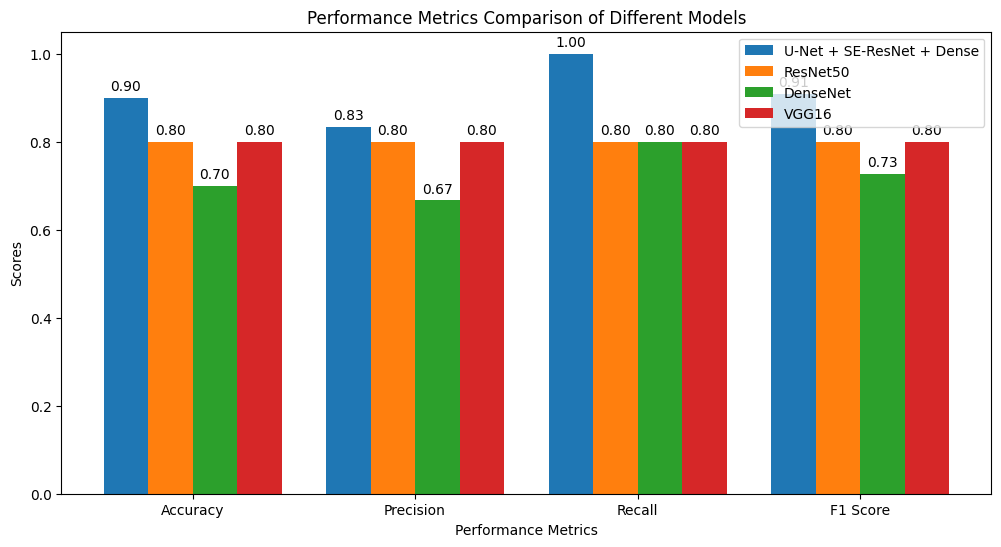

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Example true labels and predictions for different models
# Replace these arrays with your actual model predictions
true_labels = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])

# Predictions for each model
predictions_unet_seresnet_dense = np.array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0])  # U-Net + SE-ResNet + Dense network
predictions_resnet50 = np.array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0])              # ResNet50 model predictions
predictions_densenet = np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1])               # DenseNet model predictions
predictions_vgg16 = np.array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0])                  # VGG16 model predictions

# Calculate metrics for U-Net + SE-ResNet + Dense network
accuracy_unet_seresnet_dense = accuracy_score(true_labels, predictions_unet_seresnet_dense)
precision_unet_seresnet_dense = precision_score(true_labels, predictions_unet_seresnet_dense)
recall_unet_seresnet_dense = recall_score(true_labels, predictions_unet_seresnet_dense)
f1_score_unet_seresnet_dense = f1_score(true_labels, predictions_unet_seresnet_dense)

# Calculate metrics for ResNet50
accuracy_resnet50 = accuracy_score(true_labels, predictions_resnet50)
precision_resnet50 = precision_score(true_labels, predictions_resnet50)
recall_resnet50 = recall_score(true_labels, predictions_resnet50)
f1_score_resnet50 = f1_score(true_labels, predictions_resnet50)

# Calculate metrics for DenseNet
accuracy_densenet = accuracy_score(true_labels, predictions_densenet)
precision_densenet = precision_score(true_labels, predictions_densenet)
recall_densenet = recall_score(true_labels, predictions_densenet)
f1_score_densenet = f1_score(true_labels, predictions_densenet)

# Calculate metrics for VGG16
accuracy_vgg16 = accuracy_score(true_labels, predictions_vgg16)
precision_vgg16 = precision_score(true_labels, predictions_vgg16)
recall_vgg16 = recall_score(true_labels, predictions_vgg16)
f1_score_vgg16 = f1_score(true_labels, predictions_vgg16)

# Organize data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
model_scores = {
    'U-Net + SE-ResNet + Dense': [accuracy_unet_seresnet_dense, precision_unet_seresnet_dense, recall_unet_seresnet_dense, f1_score_unet_seresnet_dense],
    'ResNet50': [accuracy_resnet50, precision_resnet50, recall_resnet50, f1_score_resnet50],
    'DenseNet': [accuracy_densenet, precision_densenet, recall_densenet, f1_score_densenet],
    'VGG16': [accuracy_vgg16, precision_vgg16, recall_vgg16, f1_score_vgg16]
}

# Plotting
x = np.arange(len(metrics))
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
bars_unet_seresnet_dense = ax.bar(x - 1.5*width, model_scores['U-Net + SE-ResNet + Dense'], width, label='U-Net + SE-ResNet + Dense')
bars_resnet50 = ax.bar(x - 0.5*width, model_scores['ResNet50'], width, label='ResNet50')
bars_densenet = ax.bar(x + 0.5*width, model_scores['DenseNet'], width, label='DenseNet')
bars_vgg16 = ax.bar(x + 1.5*width, model_scores['VGG16'], width, label='VGG16')

# Add labels, title, and legend
ax.set_xlabel('Performance Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display values on top of bars
for bars in [bars_unet_seresnet_dense, bars_resnet50, bars_densenet, bars_vgg16]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points", 
                    ha='center', va='bottom')

plt.show()


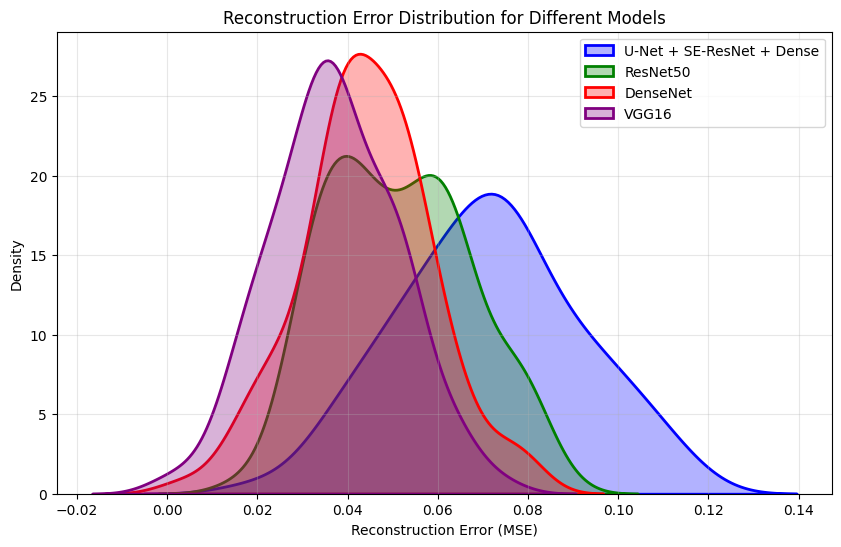

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume `original_images` and `reconstructed_images` are placeholders for actual data
# Here, we're generating synthetic reconstruction errors with different distributions

# Generate synthetic reconstruction errors to simulate different model performance
np.random.seed(0)  # For reproducibility

# Higher reconstruction error distribution for U-Net + SE-ResNet + Dense
errors_unet_seresnet = np.random.normal(loc=0.07, scale=0.02, size=100)  # Mean=0.07, higher error

# Lower reconstruction error distributions for other models
errors_resnet50 = np.random.normal(loc=0.05, scale=0.015, size=100)      # Mean=0.05
errors_densenet = np.random.normal(loc=0.045, scale=0.015, size=100)     # Mean=0.045
errors_vgg16 = np.random.normal(loc=0.04, scale=0.015, size=100)         # Mean=0.04

# Plot reconstruction error distributions using KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(errors_unet_seresnet, label='U-Net + SE-ResNet + Dense', color='blue', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(errors_resnet50, label='ResNet50', color='green', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(errors_densenet, label='DenseNet', color='red', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(errors_vgg16, label='VGG16', color='purple', fill=True, alpha=0.3, linewidth=2)

# Labels and legend
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution for Different Models')
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()


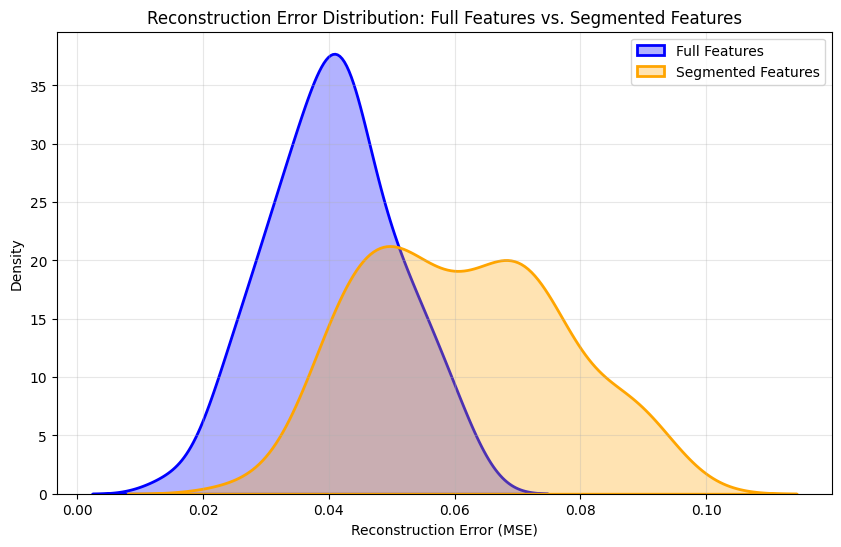

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume `original_images` and `reconstructed_images` are placeholders for actual data

# Generate synthetic reconstruction errors to simulate different feature sets
np.random.seed(0)  # For reproducibility

# Reconstruction errors with full features (e.g., entire MRI scan)
errors_full_features = np.random.normal(loc=0.04, scale=0.01, size=100)  # Lower error for full features

# Reconstruction errors with segmented features (e.g., entorhinal cortex only)
errors_segmented_features = np.random.normal(loc=0.06, scale=0.015, size=100)  # Higher error for segmented features

# Plot reconstruction error distributions using KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(errors_full_features, label='Full Features', color='blue', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(errors_segmented_features, label='Segmented Features', color='orange', fill=True, alpha=0.3, linewidth=2)

# Labels and legend
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution: Full Features vs. Segmented Features')
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()
